# Проект для «Викишоп»

___
**Описание проекта**  

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.    
___
**Цель**  

- Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.  
- Постройте модель со значением метрики качества F1 не меньше 0.75.  
___
**Инструкция по выполнению проекта.**  

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.  

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.  
___
**Описание данных:**  

Данные находятся в файле `/datasets/toxic_comments.csv`

*Признаки*

- `text` - содержит текст комментария

*Целевой признак*

- `toxic` - целевой признак

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li>
        <li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li>
        <li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li>
        <li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li>
        <li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li>
    </ul>
</div>

## Подготовка

### Импортируем необходимые библиотеки. Считаем данные из csv-файла в датафрейм и сохраним в переменную `df`. Путь к файлу:

`/datasets/toxic_comments.csv`

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy import stats as st

In [3]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
import torch
import transformers
from tqdm import notebook

#Инициализация модели LogisticRegression
from sklearn.linear_model import LogisticRegression

#Инициализация модели LinearSVC
from sklearn.svm import LinearSVC

#Разделение выборки в заданных пропорциях. Поиск лучших параметров модели
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#Метрики классификации
from sklearn.metrics import f1_score, accuracy_score

#Последовательное перемешивание массивов или разреженных матриц
from sklearn.utils import shuffle

#Сохранение и загрузка обученной модели
import joblib

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
try:
    df = pd.read_csv('./toxic_comments.csv')
except:
    print('File_not_found')

### Изучим общую информацию о полученном датафрейме

**Добавим настройки для удобства отображения данных**

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(suppress=True)

#Если необходимо вернуть дефолтные настройки, раскомментируй строку ниже
#pd.reset_option('all')

**Выведем первые 10 строчек датафрейма `df` на экран.**

In [6]:
df.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


**Посмотрим на размер данных (количество строк, колонок).**

In [7]:
print(f'\nКоличество строк: {df.shape[0]}\nКоличество колонок: {df.shape[1]}\n')


Количество строк: 159292
Количество колонок: 3



**Просмотрим статистическую сводку каждой колонки, чтобы узнать распределение данных в каждой колонки. Используем метод `describe()`.**

In [8]:
df.describe(include = "all")

,Unnamed: 0,text,toxic
count,"159,292.00",159292,"159,292.00"
unique,NaN,159292,NaN
top,NaN,"""\n\n Table size dispute on How the Earth Was ...",NaN
freq,NaN,1,NaN
mean,"79,725.70",NaN,0.10
std,"46,028.84",NaN,0.30
min,0.00,NaN,0.00
25%,"39,872.75",NaN,0.00
50%,"79,721.50",NaN,0.00
75%,"119,573.25",NaN,0.00


- `text` — признак
- `toxic` — целевой признак

**Выведем основную информацию о датафрейме с помощью метода `info()`.**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


**Выведем количество пропущенных значений для каждой колонки.**

In [10]:
pd.DataFrame(df.isna().sum()).style.background_gradient('coolwarm')

,0
Unnamed: 0,0
text,0
toxic,0


**Выведем пропущенные значения в процентном соотношении.**

In [11]:
pd.DataFrame(df.isna().mean()).style.format("{:.2%}").background_gradient('coolwarm')

,0
Unnamed: 0,0.00%
text,0.00%
toxic,0.00%


**Проверим дубликаты.**

In [12]:
df.duplicated().sum()

0

**Посмотрим на токсичные комментарии.**

In [13]:
df.query('toxic == 1')

,Unnamed: 0,text,toxic
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,16,"Bye! \n\nDon't look, come or think of comming ...",1
42,42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
...,...,...,...
159215,159374,"""\n\n our previous conversation \n\nyou fuckin...",1
159235,159394,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1
159262,159421,Your absurd edits \n\nYour absurd edits on gre...,1
159267,159426,"""\n\nHey listen don't you ever!!!! Delete my e...",1


**Посмотрим на распределение целевого признака `toxic`.**

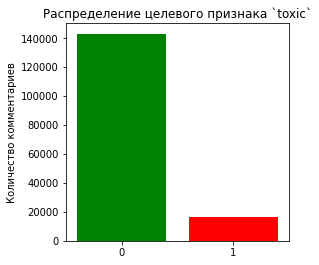

In [14]:
plt.figure(figsize=(4, 4))
palette = {0: 'green', 1: 'red'}
sns.countplot(data=df, x='toxic', palette=palette, saturation=1)
plt.xlabel(None)
plt.ylabel('Количество комментариев')
plt.title('Распределение целевого признака `toxic`')
plt.show()

In [15]:
print(f"Процент объектов класса 1 к общему объёму датасета: {(sum(df['toxic']) / len(df) * 100):.2f}%")

Процент объектов класса 1 к общему объёму датасета: 10.16%


>**Проблем с данными не выявлено**

### Подготовим данные для векторизации

#### Проведём лемматизацию слов с помощью `WordNetLemmatizer()` из библиотеки `nltk`

In [16]:
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

#### Удалим пунктуацию и лишние пробелы

In [17]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(text.split())

In [18]:
corpus = df['text'].values.astype('U')

In [19]:
corpus_lemm = [lemmatize(clear_text(corpus[i])) for i in range(len(corpus))]

#### Удалим стоп-слова (пока загрузим список, удалять будем в процессе tf-idf векторизации)

In [20]:
stopwords = set(nltk_stopwords.words('english'))

#### Разделим данные на тренировочную и тестовую выборки

In [21]:
X_train, X_test, y_train, y_test = train_test_split(corpus_lemm, df['toxic'], 
                                                    test_size=0.2,
                                                    random_state=42)

In [22]:
len(X_train), len(X_test), len(y_train), len(y_test)

(127433, 31859, 127433, 31859)

#### Проведём векторизацию корпусов с помощью TfidfVectorizer, заодно удалим стоп-слова. Попробуем обучить модель без использования n-gramm

In [23]:
tf_idf_vec = TfidfVectorizer(ngram_range=(1,1), stop_words=stopwords, min_df=3, max_df=0.9,
                             strip_accents='unicode', use_idf=1, smooth_idf=1, sublinear_tf=1)

In [24]:
X_train_vec = tf_idf_vec.fit_transform(X_train)

In [25]:
X_test_vec = tf_idf_vec.transform(X_test)

In [26]:
print(f"Размер тренировочного датасета: {X_train_vec.shape}")
print(f"Размер тренировочного датасета: {X_test_vec.shape}")

Размер тренировочного датасета: (127433, 41662)
Размер тренировочного датасета: (31859, 41662)


## Обучение

**Обучим различные модели и добавим модели и рассчитанный показатель f1 в массив.**

In [53]:
train_models = []

### Logistic Regression

In [28]:
model = LogisticRegression()

parameters = {'C': np.linspace(10, 20, num = 11, endpoint = True),
             'max_iter': [1000]}
clf = GridSearchCV(model,
                   parameters,
                   cv=5,
                   scoring='f1',
                   n_jobs=-1,
                   verbose=2)

In [29]:
%%time

clf.fit(X_train_vec, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV] END ..............................C=10.0, max_iter=1000; total time=  55.6s
[CV] END ..............................C=10.0, max_iter=1000; total time=  42.8s
[CV] END ..............................C=10.0, max_iter=1000; total time= 1.1min
[CV] END ..............................C=10.0, max_iter=1000; total time= 1.2min
[CV] END ..............................C=10.0, max_iter=1000; total time=  57.2s
[CV] END ..............................C=11.0, max_iter=1000; total time=  58.1s
[CV] END ..............................C=11.0, max_iter=1000; total time= 1.2min
[CV] END ..............................C=11.0, max_iter=1000; total time= 1.2min
[CV] END ..............................C=11.0, max_iter=1000; total time= 1.2min
[CV] END ..............................C=11.0, max_iter=1000; total time= 1.1min
[CV] END ..............................C=12.0, max_iter=1000; total time= 1.1min
[CV] END ..............................C=12.0, m

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.]),
                         'max_iter': [1000]},
             scoring='f1', verbose=2)

In [30]:
print(f"Наилучший показатель f1 на кросс-валидации : {clf.best_score_:.3f}")
print(f"Параметр регуляризации для лучшей модели: {clf.best_params_}")

Наилучший показатель f1 на кросс-валидации : 0.773
Параметр регуляризации для лучшей модели: {'C': 12.0, 'max_iter': 1000}


In [54]:
train_models.append([clf, clf.best_score_])

### LinearSVC

In [40]:
parameters = {'C': np.linspace(1, 31, num = 7, endpoint = True)}
model = LinearSVC(max_iter = 1000)
clf_lsvc = GridSearchCV(model,
                        parameters,
                        cv=5,
                        scoring='f1',
                        n_jobs=-1,
                        verbose=2)

In [41]:
clf_lsvc.fit(X_train_vec, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ..............................................C=1.0; total time=   0.4s
[CV] END ..............................................C=1.0; total time=   0.4s
[CV] END ..............................................C=1.0; total time=   0.4s
[CV] END ..............................................C=1.0; total time=   0.4s
[CV] END ..............................................C=1.0; total time=   0.4s
[CV] END ..............................................C=6.0; total time=   1.1s
[CV] END ..............................................C=6.0; total time=   1.1s
[CV] END ..............................................C=6.0; total time=   1.1s
[CV] END ..............................................C=6.0; total time=   1.1s
[CV] END ..............................................C=6.0; total time=   1.1s
[CV] END .............................................C=11.0; total time=   1.7s
[CV] END ........................................

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END .............................................C=21.0; total time=   3.1s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END .............................................C=21.0; total time=   3.0s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END .............................................C=21.0; total time=   3.2s
[CV] END .............................................C=21.0; total time=   3.0s
[CV] END .............................................C=21.0; total time=   3.2s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END .............................................C=26.0; total time=   3.2s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END .............................................C=26.0; total time=   3.2s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END .............................................C=26.0; total time=   3.0s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END .............................................C=26.0; total time=   2.9s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END .............................................C=26.0; total time=   3.2s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END .............................................C=31.0; total time=   3.0s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END .............................................C=31.0; total time=   3.1s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END .............................................C=31.0; total time=   3.2s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END .............................................C=31.0; total time=   3.1s


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END .............................................C=31.0; total time=   3.3s


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': array([ 1.,  6., 11., 16., 21., 26., 31.])},
             scoring='f1', verbose=2)

In [42]:
print(f"Наилучший показатель f1 на кросс-валидации : {clf_lsvc.best_score_:.3f}")
print(f"Параметр регуляризации для лучшей модели: {clf_lsvc.best_params_}")

Наилучший показатель f1 на кросс-валидации : 0.776
Параметр регуляризации для лучшей модели: {'C': 1.0}


In [55]:
train_models.append([clf_lsvc, clf_lsvc.best_score_])

In [56]:
results = pd.DataFrame(train_models, columns=['model', 'f1_score'])

In [57]:
print(results)

                                               model  f1_score
0  GridSearchCV(cv=5, estimator=LogisticRegressio...      0.77
1  GridSearchCV(cv=5, estimator=LinearSVC(), n_jo...      0.78


## Тестирование

**Лучший результат показала модель `LogisticRegression`. Возьмём её для дальнейшего тестирования.**

In [35]:
predictions = clf.predict(X_test_vec)
f1_lr = f1_score(y_test, predictions)

In [36]:
print(f"Показатель f1 на тестовой выборке: {f1_lr:.3f}")

Показатель f1 на тестовой выборке: 0.775


## Выводы

**Данные о токсичности твитов успешно загружены и обработаны:**  

- Лемматизация проведена с помощью `WordNetLemmatizer` библиотеки `nltk`
- Знаки пунктуации, а также лишние пробелы удалены
- Стоп слова удалены (список взят из библиотеки `nltk`)
- Корпус векторизован с помощью `TfidfVectorizer`  

**На получившихся данных обучены модели: `LogisticRegression`, `LinearSVC`**

|Модель            |f1 score|
|------------------|--------|
|LogisticRegression|   0.773|
|LinearSVC         |   0.776|

**Качество моделей практически одинаково. Разница не более `2%`.**  
**Максимальный показатель `f1` на тестовой выборке для `LogisticRegression`: `0.775`**  

**Кросс-валидация моделей и подбор гиперпараметров проводились с помощью `GridSearchCV`.**

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны